In [1]:
# Путь к экземплярам тестов и результам их вычисления
# Директория, где расположены json'ы
default_problem_instances_path = "./data"

In [3]:
import os
import json
import asyncio
import itertools
import aiofiles
import aiofiles.os
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm.notebook import trange, tqdm

In [4]:
# Константы

INF = float("inf")

In [5]:
import lib.config

lib.config.global_config["default_problem_instances_path"] = default_problem_instances_path

In [6]:
import lib.experiments
import lib.utils
import lib.lp
import lib.lap

from lib.utils import (
    mat2d,
    mat3d,
    deep_round,
    nget,
)

from lib.experiments import (
    PILStd,
    PILVerbose0,
    calc_obj_from_mat,
    calc_obj_from_vec,
    mat2d_lap_sol_into_vec,
    vec_lap_sol_into_mat2d,
    mat3d_lp_sol_into_vec,
    vec_lp_sol_into_mat3d,
    get_schedule_vec,
    get_processed_intime_jobs,
    has_mutual_job_intersection,
    has_job_preemptions,
    get_job_time_slots,
    is_job_intersects,
    get_job_time_slots,
)

In [7]:
def is_int_lp_solution(x_lp_vec):
    for _, v in x_lp_vec:
        if 0 < v < 1:
            return False
    return True

In [8]:
def _x_lap_vec_into_schedule_vec(x_lap_vec, params):
        x_mat2d = vec_lap_sol_into_mat2d(x_lap_vec)
        x_mat3d = mat3d(x_mat2d, params["p"])
        return get_schedule_vec(x_mat3d)

In [9]:
def get_number_of_preemptions(s):
    job_times = get_job_time_slots(s)
    n_pmtn = 0
    for i in range(1, len(s)):
        t = i + 1
        j_prev = s[i-1]
        j_curr = s[i]
        if (j_curr != j_prev) and (t < job_times[j_prev][-1]):
            n_pmtn += 1
    return n_pmtn

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [11]:
# Загрузить задачи с диска.
# Собрать их в таблицу для подсчета статистики

def main():
    global problem_instances_df
    
    _table = []
    
    pil = PILStd(default_problem_instances_path + "/json")
    
    for row in tqdm(pil):
        params = row["params"]
        n = len(nget(row, ["params", "p"], []))
        p = nget(row, ["params", "p", 0])

        x_lp_vec = nget(row, ["results", "lp", "x"])
        
        x_lap_vec = nget(row, ["results", "osp_lap_bnb_lc_arc", "x"]) or nget(row, ["results", "osp_blp", "x"])

        if not x_lap_vec:
            continue

        schedule_vec = _x_lap_vec_into_schedule_vec(x_lap_vec, params)
        all_intime   = all(get_processed_intime_jobs(schedule_vec, row["params"]))
        intersec     = has_mutual_job_intersection(schedule_vec)
        preempt      = has_job_preemptions(schedule_vec)
        n_preempt    = get_number_of_preemptions(schedule_vec)
        utol_correct = nget(row, ["results", "osp_blp", "obj"]) == nget(row, ["results", "osp_lap_bnb_lc_arc_utol", "obj"])
        
        test_types = row["results"].keys()
        
        test_props = {
            "obj": -1,
            "exec_time": -1,
            "n_tree_nodes": 0,
            "n_lap_solved": 0,
            "n_branching": 0,
            "n_created_w": 0,
            "stop_reason": "",
        }

        _table_row = {
            "n": n,
            "p": p,
            "np": n*p,
            "all_intime": int(all_intime),
            "intersec": int(intersec),
            "preempt": int(preempt),
            "n_preempt": n_preempt,
            "osp_lap_bnb_lc_arc_utol.correct": int(utol_correct),
            "lp.int": int(is_int_lp_solution(x_lp_vec) if x_lp_vec else -1),
        }
        
        for test_type in test_types:
            for prop in test_props:
                defval = test_props[prop]
                val = nget(row, ["results", test_type, prop], defval)
                val = defval if val is None else val
                _table_row[f"{test_type}.{prop}"] = val
        
        _table.append(_table_row)
        
    problem_instances_df = pd.DataFrame(_table).sort_values(by="np")
    problem_instances_df.fillna(-1, inplace=True)
main()

0it [00:00, ?it/s]

In [12]:
print("Сводная таблица данных")
display(problem_instances_df)

Сводная таблица данных


,n,p,np,all_intime,intersec,preempt,n_preempt,osp_lap_bnb_lc_arc_utol.correct,lp.int,wsrpt.obj,wsrpt.exec_time,wsrpt.n_tree_nodes,wsrpt.n_lap_solved,wsrpt.n_branching,wsrpt.n_created_w,wsrpt.stop_reason,lp.obj,lp.exec_time,lp.n_tree_nodes,lp.n_lap_solved,lp.n_branching,lp.n_created_w,lp.stop_reason,a1.obj,a1.exec_time,a1.n_tree_nodes,a1.n_lap_solved,a1.n_branching,a1.n_created_w,a1.stop_reason,a2.obj,a2.exec_time,a2.n_tree_nodes,a2.n_lap_solved,a2.n_branching,a2.n_created_w,a2.stop_reason,osp_blp.obj,osp_blp.exec_time,osp_blp.n_tree_nodes,osp_blp.n_lap_solved,osp_blp.n_branching,osp_blp.n_created_w,osp_blp.stop_reason,osp_lap_bnb_1st_arc.obj,osp_lap_bnb_1st_arc.exec_time,osp_lap_bnb_1st_arc.n_tree_nodes,osp_lap_bnb_1st_arc.n_lap_solved,osp_lap_bnb_1st_arc.n_branching,osp_lap_bnb_1st_arc.n_created_w,osp_lap_bnb_1st_arc.stop_reason,osp_lap_bnb_hc_arc.obj,osp_lap_bnb_hc_arc.exec_time,osp_lap_bnb_hc_arc.n_tree_nodes,osp_lap_bnb_hc_arc.n_lap_solved,osp_lap_bnb_hc_arc.n_branching,osp_lap_bnb_hc_arc.n_created_w,osp_lap_bnb_hc_arc.stop_reason,osp_lap_bnb_lc_arc.obj,osp_lap_bnb_lc_arc.exec_time,osp_lap_bnb_lc_arc.n_tree_nodes,osp_lap_bnb_lc_arc.n_lap_solved,osp_lap_bnb_lc_arc.n_branching,osp_lap_bnb_lc_arc.n_created_w,osp_lap_bnb_lc_arc.stop_reason,osp_lap_bnb_lc_arc_utol.obj,osp_lap_bnb_lc_arc_utol.exec_time,osp_lap_bnb_lc_arc_utol.n_tree_nodes,osp_lap_bnb_lc_arc_utol.n_lap_solved,osp_lap_bnb_lc_arc_utol.n_branching,osp_lap_bnb_lc_arc_utol.n_created_w,osp_lap_bnb_lc_arc_utol.stop_reason,osp_lap_bnb_lo_utol.obj,osp_lap_bnb_lo_utol.exec_time,osp_lap_bnb_lo_utol.n_tree_nodes,osp_lap_bnb_lo_utol.n_lap_solved,osp_lap_bnb_lo_utol.n_branching,osp_lap_bnb_lo_utol.n_created_w,osp_lap_bnb_lo_utol.stop_reason
3136,3,2,6,0,1,1,3,1,1,187,0.00,0,0,0,0,,144.00,0.51,0,0,0,0,,144,0.00,0,0,0,0,,144,0.00,0,0,0,0,,144,0.54,0,0,0,0,,144.00,0.00,1.00,1.00,0.00,0.00,,144.00,0.00,1.00,1.00,0.00,0.00,,144.00,0.00,1.00,1.00,0.00,0.00,,144.00,0.00,1.00,1.00,0.00,0.00,,144.00,0.00,1.00,1.00,0.00,0.00,
3208,3,2,6,0,1,1,3,1,1,154,0.00,0,0,0,0,,27.00,0.50,0,0,0,0,,27,0.00,0,0,0,0,,27,0.00,0,0,0,0,,27,0.50,0,0,0,0,,27.00,0.00,1.00,1.00,0.00,0.00,,27.00,0.00,1.00,1.00,0.00,0.00,,27.00,0.00,1.00,1.00,0.00,0.00,,27.00,0.00,1.00,1.00,0.00,0.00,,27.00,0.00,1.00,1.00,0.00,0.00,
3209,3,2,6,0,0,0,0,1,1,182,0.00,0,0,0,0,,48.00,0.55,0,0,0,0,,48,0.00,0,0,0,0,,48,0.00,0,0,0,0,,48,0.52,0,0,0,0,,48.00,0.00,1.00,1.00,0.00,0.00,,48.00,0.00,1.00,1.00,0.00,0.00,,48.00,0.00,1.00,1.00,0.00,0.00,,48.00,0.00,1.00,1.00,0.00,0.00,,48.00,0.00,1.00,1.00,0.00,0.00,
3210,3,2,6,0,0,1,1,1,0,276,0.00,0,0,0,0,,150.00,0.53,0,0,0,0,,150,0.00,0,0,0,0,,150,0.00,0,0,0,0,,150,0.53,0,0,0,0,,150.00,0.00,1.00,1.00,0.00,0.00,,150.00,0.00,1.00,1.00,0.00,0.00,,150.00,0.00,1.00,1.00,0.00,0.00,,150.00,0.00,1.00,1.00,0.00,0.00,,150.00,0.00,1.00,1.00,0.00,0.00,
3211,3,2,6,0,1,1,3,1,1,147,0.00,0,0,0,0,,75.00,0.53,0,0,0,0,,75,0.00,0,0,0,0,,75,0.00,0,0,0,0,,75,0.54,0,0,0,0,,75.00,0.00,1.00,1.00,0.00,0.00,,75.00,0.00,1.00,1.00,0.00,0.00,,75.00,0.00,1.00,1.00,0.00,0.00,,75.00,0.00,1.00,1.00,0.00,0.00,,75.00,0.00,1.00,1.00,0.00,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,10,10,100,0,1,1,46,0,0,7009,0.00,0,0,0,0,,360.00,3.97,0,0,0,0,,3224,0.00,0,0,0,0,,3033,0.02,0,0,0,0,,360,1161.46,0,0,0,0,,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1
27,10,10,100,0,1,1,51,0,0,4798,0.00,0,0,0,0,,266.00,3.35,0,0,0,0,,2766,0.02,0,0,0,0,,2766,0.00,0,0,0,0,,266,27.53,0,0,0,0,,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.0

In [13]:
print("""Статистика алгоритма АВиГ для задач n=5, p=5.
t_stop_limit -- вычисление задачи продолжалось свыше 90 минут и было завершено принудительно.
20 задач так и не успели завершиться.
""")
def main():
    df = problem_instances_df.copy()
    df = df[
          (df["n"] == 5) & (df["p"] == 5)
        # & (df["osp_lap_bnb_lc_arc.obj"] != -1)
        # & (df["osp_lap_bnb_lc_arc.stop_reason"] == "")
    ]
    df = df[[
        "n", "p", "osp_blp.obj", "osp_lap_bnb_lc_arc.obj",
        "osp_lap_bnb_lc_arc.exec_time", "osp_lap_bnb_lc_arc.n_lap_solved",
        "osp_lap_bnb_lc_arc.stop_reason",
    ]]
    display(df)
main()

Статистика алгоритма АВиГ для задач n=5, p=5.
t_stop_limit -- вычисление задачи продолжалось свыше 90 минут и было завершено принудительно.
20 задач так и не успели завершиться.



,n,p,osp_blp.obj,osp_lap_bnb_lc_arc.obj,osp_lap_bnb_lc_arc.exec_time,osp_lap_bnb_lc_arc.n_lap_solved,osp_lap_bnb_lc_arc.stop_reason
12784,5,5,102,144.00,0.00,37795063.00,t_stop_limit
12783,5,5,24,24.00,34.61,251213.00,
12782,5,5,222,222.00,11.33,85649.00,
12781,5,5,97,97.00,9.65,62496.00,
12776,5,5,344,344.00,3305.17,27844757.00,
12779,5,5,22,22.00,945.00,8023813.00,
12778,5,5,230,230.00,3930.41,34684279.00,
12777,5,5,38,74.00,0.00,43735040.00,t_stop_limit
12785,5,5,79,79.00,129.74,1155810.00,
12780,5,5,114,114.00,829.84,6819234.00,


Среднее процессорное время, секунды


,n,p,N,WSRPT,BLP,LP,A1,A2,LUT,LCAUT,LCA
0,3,2,1000,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.00
1,3,3,1000,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.00
2,3,4,1000,0.00,0.57,0.55,0.00,0.00,0.00,0.00,0.00
3,3,5,1000,0.00,0.55,0.49,0.00,0.00,0.09,0.07,0.10
4,3,10,500,0.00,1.58,0.64,0.00,0.00,-1.00,-1.00,-1.00
5,4,2,1000,0.00,0.44,0.44,0.00,0.00,0.00,0.00,0.00
6,4,3,1000,0.00,0.47,0.46,0.00,0.00,0.00,0.00,0.00
7,4,4,1000,0.00,0.55,0.47,0.00,0.00,0.13,0.09,0.14
8,4,5,100,0.00,0.73,0.48,0.00,0.00,6.43,4.52,7.38
9,4,10,500,0.00,4.91,0.70,0.00,0.00,-1.00,-1.00,-1.00


,n,p,N,WSRPT,BLP,LP,A1,A2,LUT,LCAUT,LCA,np
0,3,2,1000,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.00,6
5,4,2,1000,0.00,0.44,0.44,0.00,0.00,0.00,0.00,0.00,8
10,5,2,1000,0.00,0.47,0.46,0.00,0.00,0.00,0.00,0.00,10


,n,p,N,WSRPT,BLP,LP,A1,A2,LUT,LCAUT,LCA,np
1,3,3,1000,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.00,9
6,4,3,1000,0.00,0.47,0.46,0.00,0.00,0.00,0.00,0.00,12
11,5,3,1000,0.00,0.54,0.50,0.00,0.00,0.02,0.01,0.02,15


,n,p,N,WSRPT,BLP,LP,A1,A2,LUT,LCAUT,LCA,np
2,3,4,1000,0.00,0.57,0.55,0.00,0.00,0.00,0.00,0.00,12
7,4,4,1000,0.00,0.55,0.47,0.00,0.00,0.13,0.09,0.14,16
12,5,4,100,0.00,0.70,0.50,0.00,0.00,9.70,6.53,9.76,20


,n,p,N,WSRPT,BLP,LP,A1,A2,LUT,LCAUT,LCA,np
3,3,5,1000,0.00,0.55,0.49,0.00,0.00,0.09,0.07,0.10,15
8,4,5,100,0.00,0.73,0.48,0.00,0.00,6.43,4.52,7.38,20
13,5,5,100,0.00,1.15,0.54,0.00,0.00,685.72,554.55,652.00,25


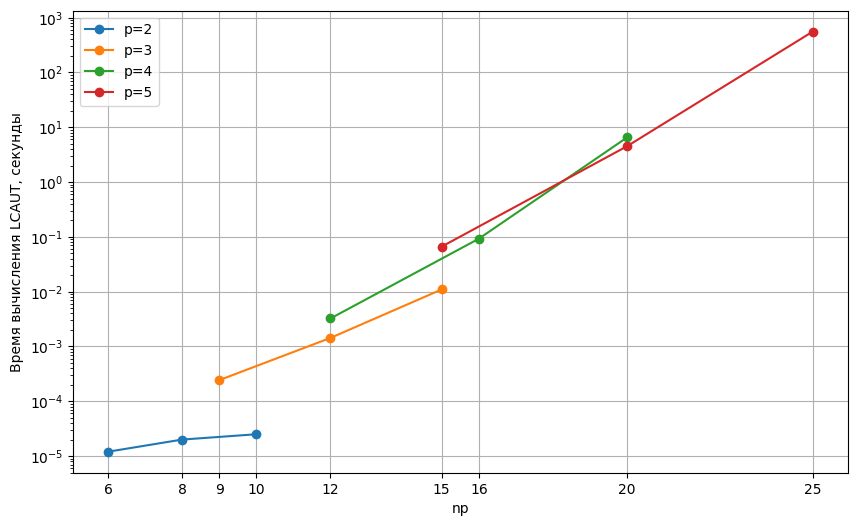

In [14]:
print("Среднее процессорное время, секунды")

def main():
    df = problem_instances_df
    cols = [
        "n",
        "p",
        "wsrpt.exec_time",
        "a1.exec_time",
        "a2.exec_time",
        "osp_lap_bnb_lo_utol.exec_time",
        "osp_lap_bnb_lc_arc_utol.exec_time",
        "osp_lap_bnb_lc_arc.exec_time",
        "lp.exec_time",
        "osp_blp.exec_time",
    ]

    df = df[cols].copy()
    df.loc[:,"N"] = 1

    result = df.groupby(['n', 'p']).agg({
        "N"                                : "count",
        "wsrpt.exec_time"                  : "mean",
        "osp_blp.exec_time"                : "mean",
        "lp.exec_time"                     : "mean",
        "a1.exec_time"                     : "mean",
        "a2.exec_time"                     : "mean",
        "osp_lap_bnb_lo_utol.exec_time"    : "mean",
        "osp_lap_bnb_lc_arc_utol.exec_time": "mean",
        "osp_lap_bnb_lc_arc.exec_time"     : "mean",
    }).reset_index().sort_values(by=["n","p"], ascending=True)

    result.columns = ["n", "p", "N", "WSRPT", "BLP", "LP", "A1", "A2", "LUT", "LCAUT", "LCA"]

    display(result)

    # -------------------------------------------------------

    result['np'] = (result['n'] * result['p'])
    p_values = result['p'].unique()
    plt.figure(figsize=(10, 6))
    for p in p_values:
        if p > 5:
            continue
        df_p = result[
              (result['p'] == p)
            & (result['LCAUT'] >= 0) # => есть данные
        ]
        df_p = df_p.sort_values('n')
        display(df_p)
        plt.plot(
            df_p['np'],
            df_p['LCAUT'],
            marker='o',
            label=f'p={p}'
        )
    x_ticks = [x for x in result['np'].unique() if x <= 25]
    plt.yscale('log')
    plt.xlabel('np')
    plt.xticks(x_ticks)
    plt.ylabel('Время вычисления LCAUT, секунды')
    plt.legend()
    plt.grid(True)
    plt.show()
main()

Количество оптимально решенных задач


,n,p,N,LP,WSRPT,A1,A2,LCAUT
0,3,2,1000,866,18,992,993,1000
1,3,3,1000,99,2,367,381,940
2,3,4,1000,7,1,98,88,962
3,3,5,1000,0,0,41,37,927
4,3,10,500,0,0,1,1,0
5,4,2,1000,914,0,993,987,1000
6,4,3,1000,25,0,122,116,955
7,4,4,1000,1,0,17,13,946
8,4,5,100,0,0,0,0,92
9,4,10,500,0,0,0,0,0


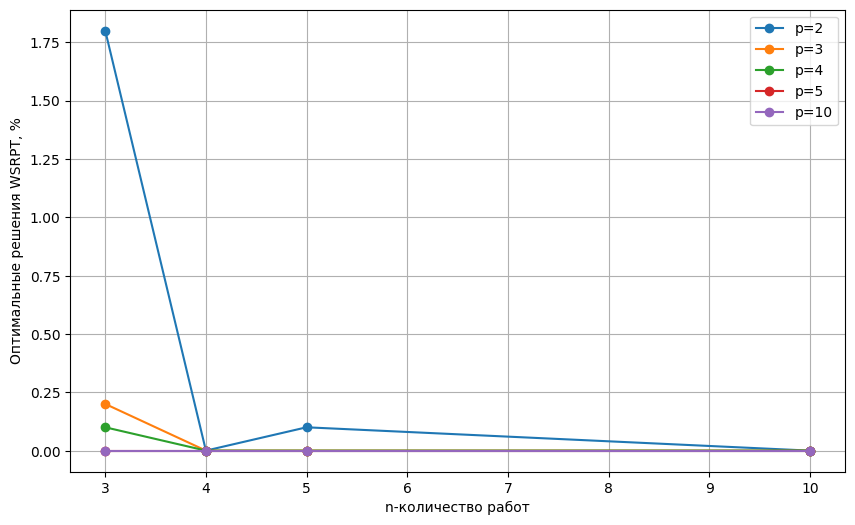

In [15]:
print("Количество оптимально решенных задач")

def main():
    df = problem_instances_df
    
    cols = [
        "n",
        "p",
        "wsrpt.obj",
        "a1.obj",
        "a2.obj",
        "lp.obj",
        "lp.int",
        "osp_blp.obj",
        "osp_lap_bnb_lc_arc_utol.obj",
    ]
    
    df = df[cols].copy()
    
    df.loc[:, "N"]     = 1
    df.loc[:, "wsrpt"] = (df["wsrpt.obj"] == df["osp_blp.obj"])
    df.loc[:, "lp"]    = (df["lp.int"])
    df.loc[:, "a1"]    = (df["a1.obj"] == df["osp_blp.obj"])
    df.loc[:, "a2"]    = (df["a2.obj"] == df["osp_blp.obj"])
    df.loc[:, "lcaut"] = (df["osp_lap_bnb_lc_arc_utol.obj"] == df["osp_blp.obj"])

    result = df.groupby(['n', 'p']).agg({
        "N"      : "count",
        "lp"     : "sum",
        "wsrpt"  : "sum",
        "a1"     : "sum",
        "a2"     : "sum",
        "lcaut"  : "sum",
    }).reset_index().sort_values(by=["n","p"], ascending=True)

    result.columns = ["n", "p", "N", "LP", "WSRPT", "A1", "A2", "LCAUT"]

    display(result)

    result['WSRPT_N_percent'] = (result['WSRPT'] / result['N']) * 100 
    p_values = result['p'].unique()
    plt.figure(figsize=(10, 6))
    for p in p_values:
        df_p = result[result['p'] == p]
        df_p = df_p.sort_values('n')
        plt.plot(
            df_p['n'],
            df_p['WSRPT_N_percent'],
            marker='o',
            label=f'p={p}'
        )
    plt.xlabel('n-количество работ')
    plt.ylabel('Оптимальные решения WSRPT, %')
    plt.legend()
    plt.grid(True)
    plt.show()
main()

In [39]:
print("Optimality gap, %")

def main():
    df = problem_instances_df
    
    cols = [
        "n",
        "p",
        "wsrpt.obj",
        "a1.obj",
        "a2.obj",
        "lp.obj",
        "lp.int",
        "osp_blp.obj",
        "osp_lap_bnb_lc_arc_utol.obj",
    ]
    
    df = df[cols].copy()
    df = df[df['osp_blp.obj'] > 0]
    df.loc[:,'N'] = 1

    df['wsrpt.optrgap'] = (df['wsrpt.obj'] - df['osp_blp.obj']) / (df['osp_blp.obj']) * 100
    df['a1.optrgap']    = (df['a1.obj']    - df['osp_blp.obj']) / (df['osp_blp.obj']) * 100
    df['a2.optrgap']    = (df['a2.obj']    - df['osp_blp.obj']) / (df['osp_blp.obj']) * 100
    df['lcaut.optrgap'] = (df['osp_lap_bnb_lc_arc_utol.obj'] - df['osp_blp.obj']) / (df['osp_blp.obj']) * 100
    

    result = df.groupby(['n', 'p']).agg({
        "N"              : "count",
        "wsrpt.optrgap"  : "mean",
        "a1.optrgap"     : "mean",
        "a2.optrgap"     : "mean",
        "lcaut.optrgap"  : "mean",
    }).reset_index().sort_values(by=["n","p"], ascending=True)

    result.columns = ["n", "p", "N", "WSRPT%", "A1%", "A2%", "LCAUT%"]

    display(result)
main()

Optimality gap, %


,n,p,N,WSRPT%,A1%,A2%,LCAUT%
0,3,2,982,244.37,0.28,0.85,0.00
1,3,3,966,435.19,110.58,110.37,2.04
2,3,4,978,521.02,267.00,273.99,1.26
3,3,5,976,486.07,287.16,300.23,1.58
4,3,10,497,897.59,362.86,369.96,-101.74
5,4,2,996,282.59,0.26,1.11,0.00
6,4,3,983,576.32,217.43,219.58,0.94
7,4,4,980,663.85,345.55,353.43,0.82
8,4,5,98,852.74,563.01,588.47,4.87
9,4,10,497,980.54,577.91,594.34,-101.16


In [17]:
print("Количество решенных ЗН. 1A, LCA, HCA. Мин., макс., медиана. Квантиль 0.05 <= n_lap <= 0.95")

def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            # df = df[df["osp_lap_bnb_lc_arc.n_lap_solved"] > 1]
            # df_lc = df_hc = df_1st = df

            qcol = "osp_lap_bnb_lc_arc.n_lap_solved"
            q0, q1 = df[qcol].quantile(0.05), df[qcol].quantile(0.95)
            df_lc = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_hc_arc.n_lap_solved"
            q0, q1 = df[qcol].quantile(0.05), df[qcol].quantile(0.95)
            df_hc = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_1st_arc.n_lap_solved"
            q0, q1 = df[qcol].quantile(0.05), df[qcol].quantile(0.95)
            df_1st = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,
                "N"          : n_tests,
                
                "1sta.mean_n_lap": df["osp_lap_bnb_1st_arc.n_lap_solved"].mean(),
                "hca.mean_n_lap" : df["osp_lap_bnb_hc_arc.n_lap_solved"].mean(),
                "lca.mean_n_lap" : df["osp_lap_bnb_lc_arc.n_lap_solved"].mean(),
                
                "q_1sta.mean_n_lap": df_1st["osp_lap_bnb_1st_arc.n_lap_solved"].mean(),
                "q_hca.mean_n_lap" : df_hc["osp_lap_bnb_hc_arc.n_lap_solved"].mean(),
                "q_lca.mean_n_lap" : df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].mean(),
                
                "q_1sta.min_n_lap": df_1st["osp_lap_bnb_1st_arc.n_lap_solved"].min(),
                "q_hca.min_n_lap" : df_hc["osp_lap_bnb_hc_arc.n_lap_solved"].min(),
                "q_lca.min_n_lap" : df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].min(),

                "q_1sta.med_n_lap": df_1st["osp_lap_bnb_1st_arc.n_lap_solved"].median(),
                "q_hca.med_n_lap" : df_hc["osp_lap_bnb_hc_arc.n_lap_solved"].median(),
                "q_lca.med_n_lap" : df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].median(),
                
                "q_1sta.max_n_lap": df_1st["osp_lap_bnb_1st_arc.n_lap_solved"].max(),
                "q_hca.max_n_lap" : df_hc["osp_lap_bnb_hc_arc.n_lap_solved"].max(),
                "q_lca.max_n_lap" : df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].max(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    display(df)
main()

Количество решенных ЗН. 1A, LCA, HCA. Мин., макс., медиана. Квантиль 0.05 <= n_lap <= 0.95


,n,p,np,N,1sta.mean_n_lap,hca.mean_n_lap,lca.mean_n_lap,q_1sta.mean_n_lap,q_hca.mean_n_lap,q_lca.mean_n_lap,q_1sta.min_n_lap,q_hca.min_n_lap,q_lca.min_n_lap,q_1sta.med_n_lap,q_hca.med_n_lap,q_lca.med_n_lap,q_1sta.max_n_lap,q_hca.max_n_lap,q_lca.max_n_lap
0,3,2,6,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,3,3,9,1000,9.52,9.91,9.28,8.21,8.60,8.05,1.00,1.00,1.00,7.00,7.00,7.00,27.00,29.00,26.00
2,3,4,12,1000,126.34,133.87,110.01,100.52,107.68,89.69,1.00,1.00,1.00,67.00,71.00,61.00,429.00,442.00,384.00
3,3,5,15,1000,2263.21,2424.88,1837.84,1532.75,1651.70,1309.32,1.00,1.00,1.00,613.00,679.50,583.00,9405.00,9424.00,7540.00
4,4,2,8,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
5,4,3,12,1000,52.80,55.97,48.75,42.72,45.27,39.70,1.00,1.00,1.00,31.50,32.50,29.00,167.00,180.00,155.00
6,4,4,16,1000,3199.06,3397.65,2416.50,2321.51,2470.33,1758.58,4.00,4.00,4.00,1199.00,1265.50,982.50,13541.00,13964.00,9150.00
7,4,5,20,100,140677.74,152499.78,94333.76,96262.96,104188.84,70531.77,22.00,22.00,22.00,32384.00,41490.50,28329.00,677436.00,725228.00,424870.00
8,5,2,10,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,5,3,15,1000,306.77,325.64,280.17,226.66,239.68,203.36,4.00,4.00,4.00,131.00,138.00,118.00,1140.00,1181.00,1125.00


In [18]:
# Средние значения числа решенных ЗН. LCA, LCAUT, LUT.

def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,
                "N"          : n_tests,
                
                "%lca.n_lap_1": (df["osp_lap_bnb_lc_arc.n_lap_solved"] == 1).mean(),
                "%lca_ut_eq": df["osp_lap_bnb_lc_arc_utol.correct"].mean(),
                
                "lca.mean_n_lap": df["osp_lap_bnb_lc_arc.n_lap_solved"].mean(),
                "lca_ut.mean_n_lap": df["osp_lap_bnb_lc_arc_utol.n_lap_solved"].mean(),
                "lut.mean_n_lap": df["osp_lap_bnb_lo_utol.n_lap_solved"].mean(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Средние значения числа решенных ЗН")
    display(df)

main()

Средние значения числа решенных ЗН


,n,p,np,N,%lca.n_lap_1,%lca_ut_eq,lca.mean_n_lap,lca_ut.mean_n_lap,lut.mean_n_lap
0,3,2,6,1000,1.00,1.00,1.00,1.08,1.17
1,3,3,9,1000,0.19,0.94,9.28,9.25,14.34
2,3,4,12,1000,0.14,0.96,110.01,98.24,142.76
3,3,5,15,1000,0.09,0.93,1837.84,1498.45,2239.02
4,4,2,8,1000,1.00,1.00,1.00,1.12,1.23
5,4,3,12,1000,0.07,0.95,48.75,44.36,73.50
6,4,4,16,1000,0.04,0.95,2416.50,1976.74,3039.41
7,4,5,20,100,0.01,0.92,94333.76,70459.33,112329.07
8,5,2,10,1000,1.00,1.00,1.00,1.17,1.34
9,5,3,15,1000,0.02,0.93,280.17,243.47,398.81


In [19]:
# Средние значения числа решенных ЗН. Квантиль 0.05 <= n_lap <= 0.95

def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            qcol = "osp_lap_bnb_lc_arc.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lc_arc_utol.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lo_utol.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lo_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]
            
            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,
                "N"          : n_tests,
                
                "%q_lca.n_lap_1": (df_lc["osp_lap_bnb_lc_arc.n_lap_solved"] == 1).mean(),
                "%q_lca_ut.eq": df_lc_utol["osp_lap_bnb_lc_arc_utol.correct"].mean(),
                
                "q_lca.mean_n_lap": df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].mean(),
                "q_lca_ut.mean_n_lap": df_lc_utol["osp_lap_bnb_lc_arc_utol.n_lap_solved"].mean(),
                "q_lut.mean_n_lap": df_lo_utol["osp_lap_bnb_lo_utol.n_lap_solved"].mean(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Средние значения числа решенных ЗН. Квантиль 0.05 <= n_lap <= 0.95")
    display(df)

main()

Средние значения числа решенных ЗН. Квантиль 0.05 <= n_lap <= 0.95


,n,p,np,N,%q_lca.n_lap_1,%q_lca_ut.eq,q_lca.mean_n_lap,q_lca_ut.mean_n_lap,q_lut.mean_n_lap
0,3,2,6,1000,1.00,1.00,1.00,1.08,1.17
1,3,3,9,1000,0.20,0.94,8.05,8.19,12.79
2,3,4,12,1000,0.15,0.96,89.69,82.38,119.31
3,3,5,15,1000,0.10,0.92,1309.32,1080.44,1590.38
4,4,2,8,1000,1.00,1.00,1.00,1.12,1.23
5,4,3,12,1000,0.08,0.96,39.70,37.08,61.83
6,4,4,16,1000,0.00,0.94,1758.58,1441.59,2241.75
7,4,5,20,100,0.00,0.91,70531.77,51196.84,80472.91
8,5,2,10,1000,1.00,1.00,1.00,1.17,1.34
9,5,3,15,1000,0.00,0.93,203.36,179.73,303.34


In [20]:
# Количество решенных ЗН: мин., макс., медиана
def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,

                "N"          : n_tests,

                # "%lca.n_lap_1": (df["osp_lap_bnb_lc_arc.n_lap_solved"] == 1).mean(),
                # "%lca_ut_eq": df["osp_lap_bnb_lc_arc_utol.correct"].mean(),

                "n_lca.n_lap_1": (df["osp_lap_bnb_lc_arc.n_lap_solved"] == 1).sum(),
                "n_lca_ut_eq": df["osp_lap_bnb_lc_arc_utol.correct"].sum(),

                "lca.min_n_lap": df["osp_lap_bnb_lc_arc.n_lap_solved"].min(),
                "lca_ut.min_n_lap": df["osp_lap_bnb_lc_arc_utol.n_lap_solved"].min(),
                "lut.min_n_lap": df["osp_lap_bnb_lo_utol.n_lap_solved"].min(),

                "lca.med_n_lap": df["osp_lap_bnb_lc_arc.n_lap_solved"].median(),
                "lca_ut.med_n_lap": df["osp_lap_bnb_lc_arc_utol.n_lap_solved"].median(),
                "lut.med_n_lap": df["osp_lap_bnb_lo_utol.n_lap_solved"].median(),
                
                "lca.max_n_lap": df["osp_lap_bnb_lc_arc.n_lap_solved"].max(),
                "lca_ut.max_n_lap": df["osp_lap_bnb_lc_arc_utol.n_lap_solved"].max(),
                "lut.max_n_lap": df["osp_lap_bnb_lo_utol.n_lap_solved"].max(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Количество решенных ЗН: мин., макс., медиана")
    display(df)

main()

Количество решенных ЗН: мин., макс., медиана


,n,p,np,N,n_lca.n_lap_1,n_lca_ut_eq,lca.min_n_lap,lca_ut.min_n_lap,lut.min_n_lap,lca.med_n_lap,lca_ut.med_n_lap,lut.med_n_lap,lca.max_n_lap,lca_ut.max_n_lap,lut.max_n_lap
0,3,2,6,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
1,3,3,9,1000,191,940,1.00,1.00,1.00,7.00,8.00,12.00,77.00,62.00,86.00
2,3,4,12,1000,141,962,1.00,1.00,1.00,68.50,63.00,89.00,910.00,806.00,1360.00
3,3,5,15,1000,91,927,1.00,1.00,1.00,639.00,553.50,811.00,23540.00,20896.00,34200.00
4,4,2,8,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
5,4,3,12,1000,73,955,1.00,1.00,1.00,31.50,30.00,49.00,441.00,382.00,806.00
6,4,4,16,1000,39,946,1.00,1.00,1.00,982.50,791.50,1190.50,85611.00,68026.00,104934.00
7,4,5,20,100,1,92,1.00,2.00,3.00,28329.00,22246.50,30391.00,997868.00,780956.00,1369134.00
8,5,2,10,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
9,5,3,15,1000,21,932,1.00,1.00,1.00,119.50,108.00,175.50,9057.00,6537.00,8114.00


In [21]:
# Количество решенных ЗН: мин., макс., медиана. Квантиль 0.05 <= n_lap <= 0.95
def main():
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]
    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[(df["n"] == n) & (df["p"] == p)]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            qcol = "osp_lap_bnb_lc_arc.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lc_arc_utol.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lo_utol.n_lap_solved"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lo_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,

                "N_lca"      : df_lc.shape[0],
                "N_lca_ut"   : df_lc_utol.shape[0],
                "N_lut"      : df_lo_utol.shape[0],

                "q_n_lca.n_lap_1": (df_lc["osp_lap_bnb_lc_arc.n_lap_solved"] == 1).sum(),
                "q_n_lca_ut_eq": df_lc_utol["osp_lap_bnb_lc_arc_utol.correct"].sum(),

                "q_lca.min_n_lap": df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].min(),
                "q_lca_ut.min_n_lap": df_lc_utol["osp_lap_bnb_lc_arc_utol.n_lap_solved"].min(),
                "q_lut.min_n_lap": df_lo_utol["osp_lap_bnb_lo_utol.n_lap_solved"].min(),

                "q_lca.med_n_lap": df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].median(),
                "q_lca_ut.med_n_lap": df_lc_utol["osp_lap_bnb_lc_arc_utol.n_lap_solved"].median(),
                "q_lut.med_n_lap": df_lo_utol["osp_lap_bnb_lo_utol.n_lap_solved"].median(),
                
                "q_lca.max_n_lap": df_lc["osp_lap_bnb_lc_arc.n_lap_solved"].max(),
                "q_lca_ut.max_n_lap": df_lc_utol["osp_lap_bnb_lc_arc_utol.n_lap_solved"].max(),
                "q_lut.max_n_lap": df_lo_utol["osp_lap_bnb_lo_utol.n_lap_solved"].max(),
            }

            _table.append(_row)
        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Количество решенных ЗН: мин., макс., медиана. Квантиль 0.05 <= n_lap <= 0.95")
    display(df)
main()

Количество решенных ЗН: мин., макс., медиана. Квантиль 0.05 <= n_lap <= 0.95


,n,p,np,N_lca,N_lca_ut,N_lut,q_n_lca.n_lap_1,q_n_lca_ut_eq,q_lca.min_n_lap,q_lca_ut.min_n_lap,q_lut.min_n_lap,q_lca.med_n_lap,q_lca_ut.med_n_lap,q_lut.med_n_lap,q_lca.max_n_lap,q_lca_ut.max_n_lap,q_lut.max_n_lap
0,3,2,6,1000,1000,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
1,3,3,9,953,955,956,191,897,1.00,1.00,1.00,7.00,8.00,11.00,26.00,25.00,38.00
2,3,4,12,950,932,932,141,897,1.00,2.00,3.00,61.00,59.00,83.00,384.00,329.00,457.00
3,3,5,15,950,945,945,91,873,1.00,2.00,3.00,583.00,498.00,731.00,7540.00,6315.00,10067.00
4,4,2,8,1000,1000,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
5,4,3,12,950,930,931,73,890,1.00,2.00,3.00,29.00,28.00,47.00,155.00,138.00,223.00
6,4,4,16,900,900,903,0,849,4.00,7.00,10.00,982.50,791.50,1189.00,9150.00,7601.00,11993.00
7,4,5,20,90,90,90,0,82,22.00,45.00,67.00,28329.00,22246.50,30391.00,424870.00,326088.00,492941.00
8,5,2,10,1000,1000,1000,1000,1000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
9,5,3,15,911,909,902,0,846,4.00,7.00,11.00,118.00,105.00,174.50,1125.00,1010.00,1563.00


In [22]:
# Процессорное время: медиана, мин., макс.

def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            _row = {
                "n"          : n,
                "p"          : p,

                "N"          : n_tests,

                "lca.min_t": df["osp_lap_bnb_lc_arc.exec_time"].min(),
                "lca_ut.min_t": df["osp_lap_bnb_lc_arc_utol.exec_time"].min(),
                "lut.min_t": df["osp_lap_bnb_lo_utol.exec_time"].min(),

                "lca.med_t": df["osp_lap_bnb_lc_arc.exec_time"].median(),
                "lca_ut.med_t": df["osp_lap_bnb_lc_arc_utol.exec_time"].median(),
                "lut.med_t": df["osp_lap_bnb_lo_utol.exec_time"].median(),
                
                "lca.max_t": df["osp_lap_bnb_lc_arc.exec_time"].max(),
                "lca_ut.max_t": df["osp_lap_bnb_lc_arc_utol.exec_time"].max(),
                "lut.max_t": df["osp_lap_bnb_lo_utol.exec_time"].max(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Процессорное время: медиана, мин., макс.")
    display(df)

main()

Процессорное время: медиана, мин., макс.


,n,p,N,lca.min_t,lca_ut.min_t,lut.min_t,lca.med_t,lca_ut.med_t,lut.med_t,lca.max_t,lca_ut.max_t,lut.max_t
0,3,2,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3,3,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,4,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.03,0.04
3,3,5,1000,0.00,0.00,0.00,0.03,0.02,0.03,1.32,0.95,1.36
4,4,2,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,4,3,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.03
6,4,4,1000,0.00,0.00,0.00,0.05,0.04,0.05,5.12,3.21,4.29
7,4,5,100,0.00,0.00,0.00,2.14,1.39,1.73,76.98,49.94,77.42
8,5,2,1000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,5,3,1000,0.00,0.00,0.00,0.01,0.00,0.01,0.56,0.36,0.32


In [23]:
# Процессорное время: медиана, мин., макс. Квантиль 0.05 <= n_lap <= 0.95

def main():
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]
    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[(df["n"] == n) & (df["p"] == p)]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            qcol = "osp_lap_bnb_lc_arc.exec_time"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lc_arc_utol.exec_time"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lc_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            qcol = "osp_lap_bnb_lo_utol.exec_time"
            q0 = df[qcol].quantile(0.05)
            q1 = df[qcol].quantile(0.95)
            df_lo_utol = df[(q0 <= df[qcol]) & (df[qcol] <= q1)]

            _row = {
                "n"          : n,
                "p"          : p,
                
                "N"          : df_lc.shape[0],

                "q_lca.min_t": df_lc["osp_lap_bnb_lc_arc.exec_time"].min(),
                "q_lca_ut.min_t": df_lc_utol["osp_lap_bnb_lc_arc_utol.exec_time"].min(),
                "q_lut.min_t": df_lo_utol["osp_lap_bnb_lo_utol.exec_time"].min(),

                "q_lca.med_t": df_lc["osp_lap_bnb_lc_arc.exec_time"].median(),
                "q_lca_ut.med_t": df_lc_utol["osp_lap_bnb_lc_arc_utol.exec_time"].median(),
                "q_lut.med_t": df_lo_utol["osp_lap_bnb_lo_utol.exec_time"].median(),
                
                "q_lca.max_t": df_lc["osp_lap_bnb_lc_arc.exec_time"].max(),
                "q_lca_ut.max_t": df_lc_utol["osp_lap_bnb_lc_arc_utol.exec_time"].max(),
                "q_lut.max_t": df_lo_utol["osp_lap_bnb_lo_utol.exec_time"].max(),
            }

            _table.append(_row)
        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    print("Процессорное время: медиана, мин., макс. Квантиль 0.05 <= n_lap <= 0.95")
    display(df)
main()

Процессорное время: медиана, мин., макс. Квантиль 0.05 <= n_lap <= 0.95


,n,p,N,q_lca.min_t,q_lca_ut.min_t,q_lut.min_t,q_lca.med_t,q_lca_ut.med_t,q_lut.med_t,q_lca.max_t,q_lca_ut.max_t,q_lut.max_t
0,3,2,979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3,3,997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,4,953,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.01
3,3,5,950,0.00,0.00,0.00,0.03,0.02,0.03,0.43,0.29,0.40
4,4,2,981,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,4,3,953,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01
6,4,4,950,0.00,0.00,0.00,0.05,0.03,0.04,0.53,0.36,0.50
7,4,5,90,0.00,0.00,0.00,2.14,1.39,1.72,33.47,20.09,29.39
8,5,2,984,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,5,3,950,0.00,0.00,0.00,0.01,0.00,0.01,0.07,0.05,0.07


In [24]:
print("Максимальное количество решенных ЗН, ветвлений, размер дерева")

def main():
    global exec_test_stats_df
    
    n_list = [3, 4, 5]
    p_list = [2, 3, 4, 5]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue

            _row = {
                "n"          : n,
                "p"          : p,
                # "np"         : n*p,

                "N"          : n_tests,

                "lca.max_n_lap"   : df["osp_lap_bnb_lc_arc.n_lap_solved"].max(),
                "lca_ut.max_n_lap": df["osp_lap_bnb_lc_arc_utol.n_lap_solved"].max(),
                "lut.max_n_lap"   : df["osp_lap_bnb_lo_utol.n_lap_solved"].max(),

                "lca.max_br"      : df["osp_lap_bnb_lc_arc.n_branching"].max(),
                "lca_ut.max_br"   : df["osp_lap_bnb_lc_arc_utol.n_branching"].max(),
                "lut.max_br"      : df["osp_lap_bnb_lo_utol.n_branching"].max(),
                
                "lca.max_n_tr"    : df["osp_lap_bnb_lc_arc.n_tree_nodes"].max(),
                "lca_ut.max_n_tr" : df["osp_lap_bnb_lc_arc_utol.n_tree_nodes"].max(),
                "lut.max_n_tr"    : df["osp_lap_bnb_lo_utol.n_tree_nodes"].max(),
            }

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)
    
    display(df)

main()

Максимальное количество решенных ЗН, ветвлений, размер дерева


,n,p,N,lca.max_n_lap,lca_ut.max_n_lap,lut.max_n_lap,lca.max_br,lca_ut.max_br,lut.max_br,lca.max_n_tr,lca_ut.max_n_tr,lut.max_n_tr
0,3,2,1000,1.00,2.00,3.00,0.00,0.00,0.00,1.00,1.00,1.00
1,3,3,1000,77.00,62.00,86.00,76.00,38.00,39.00,153.00,77.00,79.00
2,3,4,1000,910.00,806.00,1360.00,909.00,590.00,650.00,1819.00,1181.00,1301.00
3,3,5,1000,23540.00,20896.00,34200.00,23539.00,15495.00,17901.00,47079.00,30991.00,35803.00
4,4,2,1000,1.00,2.00,3.00,0.00,0.00,0.00,1.00,1.00,1.00
5,4,3,1000,441.00,382.00,806.00,440.00,295.00,401.00,881.00,591.00,803.00
6,4,4,1000,85611.00,68026.00,104934.00,85610.00,48602.00,54523.00,171221.00,97205.00,109047.00
7,4,5,100,997868.00,780956.00,1369134.00,997867.00,584516.00,748881.00,1995735.00,1169033.00,1497763.00
8,5,2,1000,1.00,2.00,3.00,0.00,0.00,0.00,1.00,1.00,1.00
9,5,3,1000,9057.00,6537.00,8114.00,9056.00,5285.00,4035.00,18113.00,10571.00,8071.00


Прерывание, взаимопрерывание, успеваемость: абсолютное значение, процентное отношение


,n,p,N,intm,pmtn,mean_pmtn,intrsc,%intm,%pmtn,%intrsc
0,3,2,1000,18,865,1.78,569,1.80,86.50,56.90
1,3,3,1000,34,973,2.57,801,3.40,97.30,80.10
2,3,4,1000,22,989,3.18,832,2.20,98.90,83.20
3,3,5,1000,24,992,3.63,865,2.40,99.20,86.50
4,3,10,500,3,500,5.92,463,0.60,100.00,92.60
5,4,2,1000,4,970,2.62,770,0.40,97.00,77.00
6,4,3,1000,17,997,3.72,914,1.70,99.70,91.40
7,4,4,1000,20,996,4.64,943,2.00,99.60,94.30
8,4,5,100,2,100,5.65,95,2.00,100.00,95.00
9,4,10,500,3,500,9.89,496,0.60,100.00,99.20


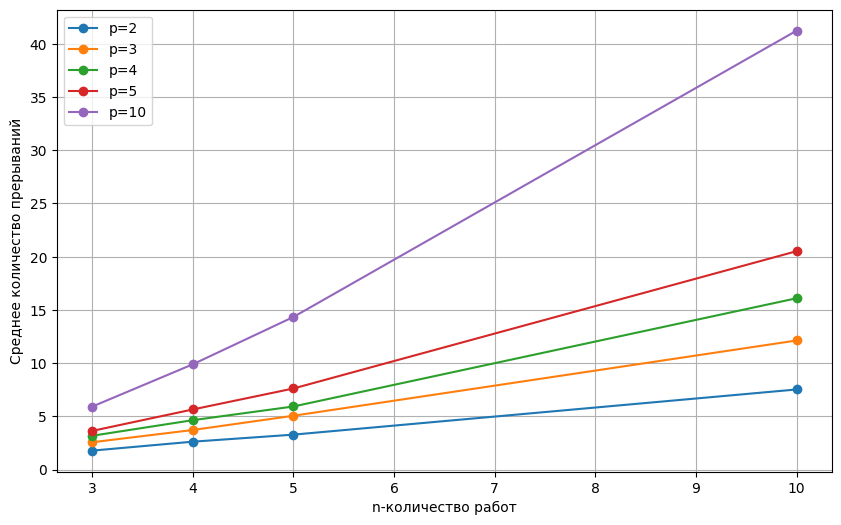

In [25]:
print("Прерывание, взаимопрерывание, успеваемость: абсолютное значение, процентное отношение")

def main():
    df = problem_instances_df
    
    cols = [
        "n",
        "p",
        "all_intime",
        "preempt",
        "n_preempt",
        "intersec",
    ]
    
    df = df[cols].copy()
    df.loc[:, "N"] = 1

    result = df.groupby(['n', 'p']).agg({
        "N"           : "count",
        "all_intime"  : "sum",
        "preempt"     : "sum",
        "n_preempt"   : "mean",
        "intersec"    : "sum",
    }).reset_index().sort_values(by=["n","p"], ascending=True)

    result["all_intime_p"] = result["all_intime"] / result["N"] * 100
    result["preempt_p"]    = result["preempt"] / result["N"] * 100
    result["intersec_p"]   = result["intersec"] / result["N"] * 100

    result.columns = ["n", "p", "N", "intm", "pmtn", "mean_pmtn", "intrsc", "%intm", "%pmtn", "%intrsc"]

    display(result)

    # --------------------------------------------

    p_values = result['p'].unique()
    plt.figure(figsize=(10, 6))
    for p in p_values:
        df_p = result[result['p'] == p]
        df_p = df_p.sort_values('n')
        plt.plot(
            df_p['n'],
            df_p['mean_pmtn'],
            marker='o',
            label=f'p={p}'
        )
    plt.xlabel('n-количество работ')
    plt.ylabel('Среднее количество прерываний')
    plt.legend()
    plt.grid(True)
    plt.show()

main()

In [26]:
def main():
    global problem_instances_pmtn_df
    
    _table = []
    
    pil = PILStd(default_problem_instances_path + "/json")
    
    for row in tqdm(pil):
        params = row["params"]
        
        n = len(nget(row, ["params", "p"], []))
        p = nget(row, ["params", "p", 0])
        
        _table_row = {
            "n": n,
            "p": p,
            "np": n*p,
        }
        
        x_lap_vec_blp = nget(row, ["results", "osp_blp", "x"])
        x_lap_vec_bnb = nget(row, ["results", "osp_lap_bnb_lc_arc", "x"])
        
        if (not x_lap_vec_blp) and (not x_lap_vec_bnb):
            continue
        
        if x_lap_vec_blp:
            s_blp   = _x_lap_vec_into_schedule_vec(x_lap_vec_blp, params)
            s_wsrpt = nget(row, ["results", "wsrpt", "s"])
            s_a1    = nget(row, ["results", "a1", "s"])
            s_a2    = nget(row, ["results", "a2", "s"])
            
            _table_row.update({
                "blp.obj"   : nget(row, ["results", "osp_blp", "obj"]),
                "wsrpt.obj" : nget(row, ["results", "wsrpt", "obj"]),
                "a1.obj"    : nget(row, ["results", "a1", "obj"]),
                "a2.obj"    : nget(row, ["results", "a2", "obj"]),
            
                "blp.pmtn"  : has_job_preemptions(s_blp),
                "wsrpt.pmtn": has_job_preemptions(s_wsrpt),
                "a1.pmtn"   : has_job_preemptions(s_a1),
                "a2.pmtn"   : has_job_preemptions(s_a2),
            })

            _table_row.update({
                "blp.opt"  : (_table_row["blp.obj"]   == _table_row["blp.obj"]),
                "wsrpt.opt": (_table_row["wsrpt.obj"] == _table_row["blp.obj"]),
                "a1.opt"   : (_table_row["a1.obj"]    == _table_row["blp.obj"]),
                "a2.opt"   : (_table_row["a2.obj"]    == _table_row["blp.obj"]),
            })
        
        if x_lap_vec_bnb:
            s_bnb = _x_lap_vec_into_schedule_vec(x_lap_vec_bnb, params)
            _table_row.update({
                "bnb.obj": nget(row, ["results", "osp_lap_bnb_lc_arc", "obj"]),
                "bnb.pmtn": has_job_preemptions(s_bnb),
            })
            _table_row["bnb.opt"] = (_table_row["bnb.obj"] == _table_row["blp.obj"])

        _table.append(_table_row)
    
    problem_instances_pmtn_df = pd.DataFrame(_table).sort_values(by="np")
    problem_instances_pmtn_df.fillna(-1, inplace=True)
main()

0it [00:00, ?it/s]

In [27]:
problem_instances_pmtn_df

,n,p,np,blp.obj,wsrpt.obj,a1.obj,a2.obj,blp.pmtn,wsrpt.pmtn,a1.pmtn,a2.pmtn,blp.opt,wsrpt.opt,a1.opt,a2.opt,bnb.obj,bnb.pmtn,bnb.opt
3136,3,2,6,144,187,144,144,True,False,True,True,True,False,True,True,144.00,True,True
3208,3,2,6,27,154,27,27,True,False,True,True,True,False,True,True,27.00,True,True
3209,3,2,6,48,182,48,48,False,True,False,False,True,False,True,True,48.00,False,True
3210,3,2,6,150,276,150,150,True,False,True,True,True,False,True,True,150.00,True,True
3211,3,2,6,75,147,75,75,True,False,True,True,True,False,True,True,75.00,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,10,10,100,360,7009,3224,3033,True,True,True,True,True,False,False,False,-1.00,-1,-1
27,10,10,100,266,4798,2766,2766,True,True,True,True,True,False,False,False,-1.00,-1,-1
26,10,10,100,186,6707,5068,5938,True,True,True,True,True,False,False,False,-1.00,-1,-1
36,10,10,100,136,4037,3350,2945,True,True,True,True,True,False,False,False,-1.00,-1,-1


,n,p,N,bnb.no_pmtn_opt,wsrpt.no_pmtn_opt,a1.no_pmtn_opt,a2.no_pmtn_opt,bnb.no_pmtn_opt_p,wsrpt.no_pmtn_opt_p,a1.no_pmtn_opt_p,a2.no_pmtn_opt_p
0,3,2,1000,135,16,137,138,13.50,1.60,13.70,13.80
1,3,3,1000,27,2,22,21,2.70,0.20,2.20,2.10
2,3,4,1000,11,1,8,6,1.10,0.10,0.80,0.60
3,3,5,1000,8,0,4,3,0.80,0.00,0.40,0.30
4,3,10,500,0,0,0,0,0.00,0.00,0.00,0.00
5,4,2,1000,30,0,33,33,3.00,0.00,3.30,3.30
6,4,3,1000,3,0,3,3,0.30,0.00,0.30,0.30
7,4,4,1000,4,0,2,0,0.40,0.00,0.20,0.00
8,4,5,100,0,0,0,0,0.00,0.00,0.00,0.00
9,4,10,500,0,0,0,0,0.00,0.00,0.00,0.00


bnb


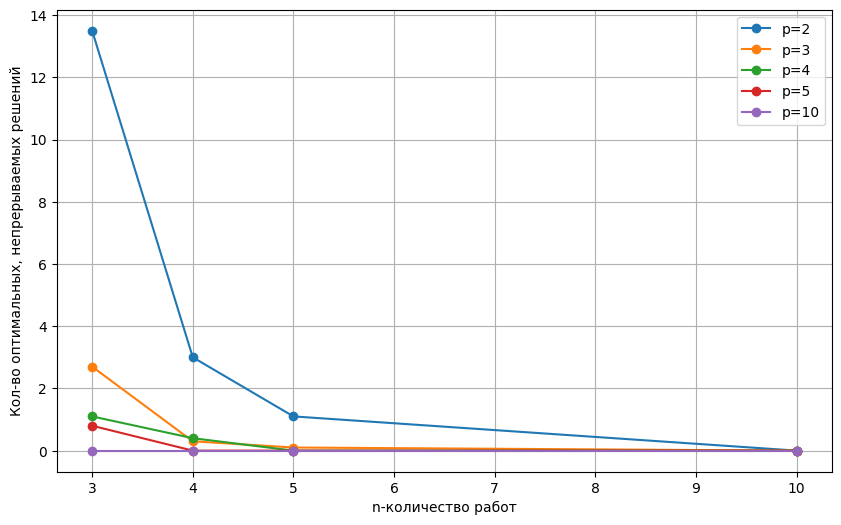

wsrpt


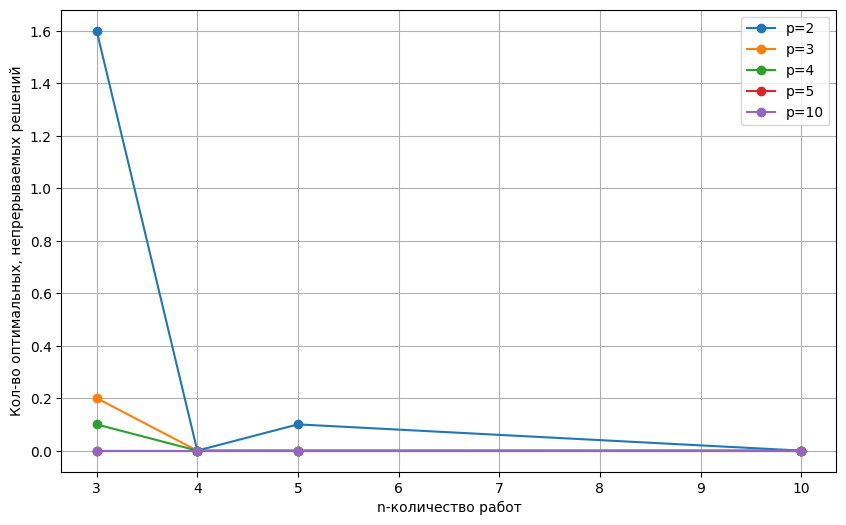

a1


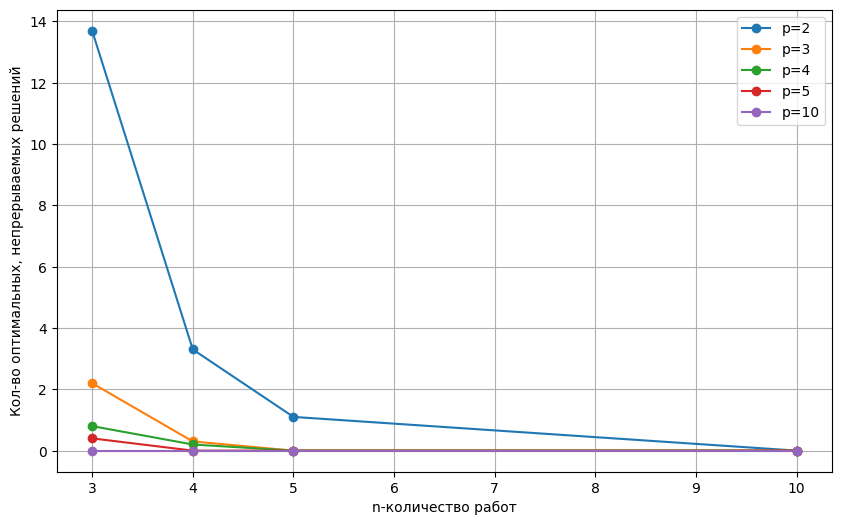

a2


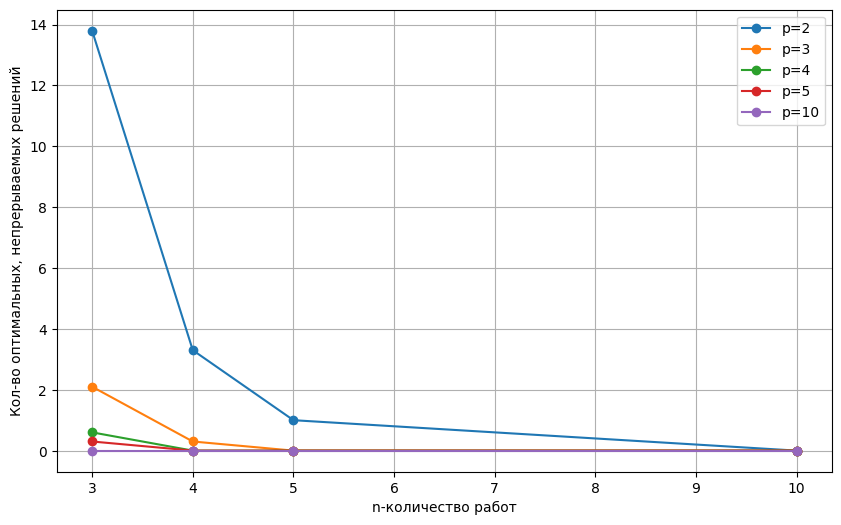

In [28]:
def main():
    df = problem_instances_pmtn_df.copy()
    df.loc[:, "N"] = 1
    
    algs = ["bnb", "wsrpt", "a1", "a2"]

    for alg in algs:
        df.loc[:, f"{alg}.no_pmtn_opt"] = (df[f"{alg}.opt"] == True) & (df[f"{alg}.pmtn"] == False)

    result = df.groupby(['n', 'p']).agg({
        "N": "count",
        "bnb.no_pmtn_opt": "sum",
        "wsrpt.no_pmtn_opt": "sum",
        "a1.no_pmtn_opt": "sum",
        "a2.no_pmtn_opt": "sum",
    }).reset_index().sort_values(by=["n","p"], ascending=True)
    
    result["bnb.no_pmtn_opt_p"]   = result["bnb.no_pmtn_opt"]   / result["N"] * 100
    result["wsrpt.no_pmtn_opt_p"] = result["wsrpt.no_pmtn_opt"] / result["N"] * 100
    result["a1.no_pmtn_opt_p"]    = result["a1.no_pmtn_opt"]    / result["N"] * 100
    result["a2.no_pmtn_opt_p"]    = result["a2.no_pmtn_opt"]    / result["N"] * 100

    display(result)

    for alg in algs:
        p_values = result['p'].unique()
        plt.figure(figsize=(10, 6))
        # display(result[['n','p','N',f'{alg}.no_pmtn_opt',f'{alg}.no_pmtn_opt_p']])
        for p in p_values:
            df_p = result[result['p'] == p]
            df_p = df_p.sort_values('n')
            plt.plot(
                df_p['n'],
                df_p[f"{alg}.no_pmtn_opt_p"],
                marker='o',
                label=f'p={p}'
            )
        print(alg)
        plt.xlabel('n-количество работ')
        plt.ylabel('Кол-во оптимальных, непрерываемых решений')
        plt.legend()
        plt.grid(True)
        plt.show()
main()